<a href="https://colab.research.google.com/github/chungntu/1DCNN-LSTM-ResNet/blob/main/Problem_18_Thin_plate_in_bending.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Displacements
  1   0.00000000
  2   0.07268022
  3   0.13847259
  4   0.20235562
  5   0.26272733
  6   0.31944050
  7   0.37248974
  8   0.42187843
  9   0.46760887
 10   0.50968090
 11   0.54809451
 12   0.58284967
 13   0.61394640
 14   0.64138470
 15   0.66516462
 16   0.68528585
 17   0.70174660
 18   0.71454437
 19   0.72371041
 20   0.72962370
 21   0.73205519
 22   0.00000000
 23   0.05422355
 24   0.10931159
 25   0.16026261
 26   0.20857481
 27   0.25393707
 28   0.29637608
 29   0.33588713
 30   0.37247153
 31   0.40612915
 32   0.43686004
 33   0.46466417
 34   0.48954155
 35   0.51149219
 36   0.53051607
 37   0.54661309
 38   0.55978300
 39   0.57002545
 40   0.57737242
 41   0.58174498
 42   0.58343300
 43   0.00000000
 44   0.03932608
 45   0.08062335
 46   0.11929665
 47   0.15548701
 48   0.18951339
 49   0.22133936
 50   0.25097292
 51   0.27841121
 52   0.30365445
 53   0.32670261
 54   0.34755571
 55   0.36621375
 56   0.38267671
 57   0.39694459
 58   0.40901770


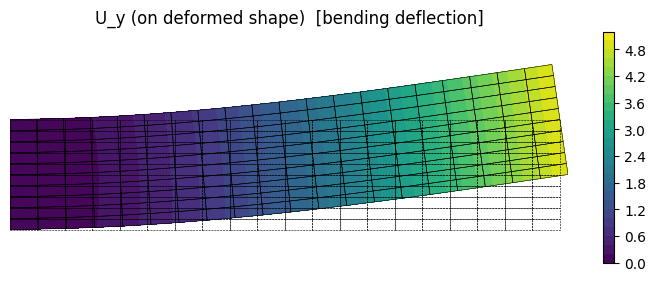

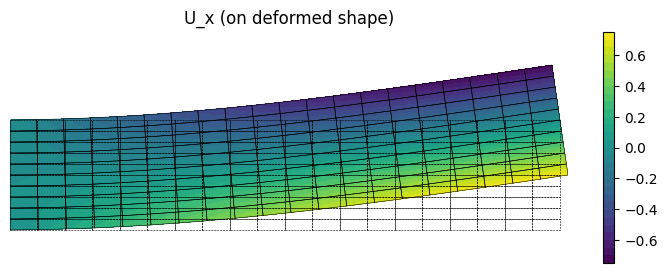

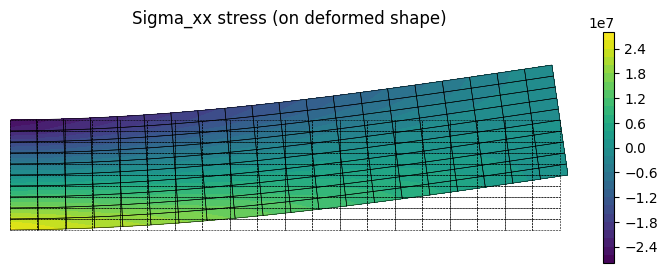

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation

# =========================
# Gauss quadrature Q4
# =========================
def gaussQuadrature(option='complete'):
    if option == 'complete':
        a = 0.577350269189626
        locations = np.array([[-a, -a],
                              [ a, -a],
                              [ a,  a],
                              [-a,  a]], dtype=float)
        weights = np.array([1, 1, 1, 1], dtype=float)
    elif option == 'reduced':
        locations = np.array([[0.0, 0.0]], dtype=float)
        weights = np.array([4.0], dtype=float)
    else:
        raise ValueError("option must be 'complete' or 'reduced'")
    return weights, locations

# =========================
# Q4 shape + derivatives
# =========================
def shapeFunctionQ4(xi, eta):
    N = 0.25 * np.array([
        (1-xi)*(1-eta),
        (1+xi)*(1-eta),
        (1+xi)*(1+eta),
        (1-xi)*(1+eta)
    ], dtype=float)

    dN = 0.25 * np.array([
        [-(1-eta), -(1-xi)],
        [ (1-eta), -(1+xi)],
        [ (1+eta),  (1+xi)],
        [-(1+eta),  (1-xi)]
    ], dtype=float)  # cols: d/dxi, d/deta
    return N, dN

def Jacobian(nodeCoords_elem, naturalDerivatives):
    J = nodeCoords_elem.T @ naturalDerivatives
    invJ = np.linalg.inv(J)
    dN_xy = naturalDerivatives @ invJ
    return J, invJ, dN_xy

# =========================
# Rectangular mesh Q4
# =========================
def rectangularMesh(Lx, Ly, nEx, nEy):
    xs = np.linspace(0.0, Lx, nEx+1)
    ys = np.linspace(0.0, Ly, nEy+1)
    X, Y = np.meshgrid(xs, ys)
    nodeCoordinates = np.column_stack([X.ravel(), Y.ravel()])

    def nid(ix, iy):
        return iy*(nEx+1) + ix + 1  # 1-based

    elems = []
    for iy in range(nEy):
        for ix in range(nEx):
            n1 = nid(ix,   iy)
            n2 = nid(ix+1, iy)
            n3 = nid(ix+1, iy+1)
            n4 = nid(ix,   iy+1)
            elems.append([n1, n2, n3, n4])
    return nodeCoordinates, np.array(elems, dtype=int)

# =========================
# formStiffness2D plane stress Q4
# =========================
def formStiffness2D(GDoF, numberElements, elementNodes, numberNodes, nodeCoordinates,
                    C, rho=1.0, thickness=1.0):
    K = np.zeros((GDoF, GDoF), dtype=float)
    M = np.zeros((GDoF, GDoF), dtype=float)

    gw, gl = gaussQuadrature('complete')

    for e in range(numberElements):
        indice = elementNodes[e, :]          # 1-based
        nodes = indice.astype(int) - 1       # 0-based

        elementDof = np.hstack([indice, indice + numberNodes]).astype(int) - 1
        ndof = 4

        for q in range(len(gw)):
            xi, eta = gl[q, 0], gl[q, 1]
            wt = gw[q]

            N, dN_nat = shapeFunctionQ4(xi, eta)
            J, invJ, dN_xy = Jacobian(nodeCoordinates[nodes, :], dN_nat)

            dNdx = dN_xy[:, 0]
            dNdy = dN_xy[:, 1]

            B = np.zeros((3, 2*ndof), dtype=float)
            B[0, 0:ndof] = dNdx
            B[1, ndof:2*ndof] = dNdy
            B[2, 0:ndof] = dNdy
            B[2, ndof:2*ndof] = dNdx

            detJ = np.linalg.det(J)
            K[np.ix_(elementDof, elementDof)] += (B.T @ C @ B) * wt * detJ * thickness

            # mass (not needed for static, but kept for completeness)
            NN = np.outer(N, N) * rho * thickness * wt * detJ
            M[np.ix_(nodes, nodes)] += NN
            M[np.ix_(nodes + numberNodes, nodes + numberNodes)] += NN

    return K, M

# =========================
# Solve with prescribed DOF = 0
# =========================
def solution(GDoF, prescribedDof_1based, K, F):
    prescribed = np.array(prescribedDof_1based, dtype=int) - 1
    all_dofs = np.arange(GDoF)
    free = np.setdiff1d(all_dofs, prescribed)

    U = np.zeros((GDoF,), dtype=float)
    U[free] = np.linalg.solve(K[np.ix_(free, free)], F[free])
    U[prescribed] = 0.0
    return U

# =========================
# stresses2D: nodal sigma_xx by averaging Gauss-point stresses
# =========================
def stresses2D(numberElements, elementNodes, numberNodes, nodeCoordinates, displacements, C):
    gw, gl = gaussQuadrature('complete')

    UX = displacements[:numberNodes]
    UY = displacements[numberNodes:]

    sigxx_sum = np.zeros(numberNodes, dtype=float)
    sigxx_cnt = np.zeros(numberNodes, dtype=float)

    for e in range(numberElements):
        indice = elementNodes[e, :]
        nodes = indice.astype(int) - 1

        ue = np.hstack([UX[nodes], UY[nodes]])  # 8

        for q in range(len(gw)):
            xi, eta = gl[q, 0], gl[q, 1]
            _, dN_nat = shapeFunctionQ4(xi, eta)
            J, invJ, dN_xy = Jacobian(nodeCoordinates[nodes, :], dN_nat)

            dNdx = dN_xy[:, 0]
            dNdy = dN_xy[:, 1]

            B = np.zeros((3, 8), dtype=float)
            B[0, 0:4] = dNdx
            B[1, 4:8] = dNdy
            B[2, 0:4] = dNdy
            B[2, 4:8] = dNdx

            strain = B @ ue
            stress = C @ strain  # [sigxx, sigyy, tauxy]

            sigxx_sum[nodes] += stress[0]
            sigxx_cnt[nodes] += 1.0

    return sigxx_sum / np.maximum(sigxx_cnt, 1.0)

# =========================
# plotting helpers
# =========================
def draw_mesh_edges(nodeCoordinates, elementNodes, ax, color='k', lw=0.5, ls='-'):
    for elem in elementNodes:
        ids = elem.astype(int) - 1
        poly = np.vstack([nodeCoordinates[ids, :], nodeCoordinates[ids[0], :]])
        ax.plot(poly[:, 0], poly[:, 1], color=color, lw=lw, ls=ls)

def q4_to_triangles(elementNodes):
    tris = []
    for e in elementNodes:
        n1, n2, n3, n4 = e.astype(int) - 1
        tris.append([n1, n2, n3])
        tris.append([n1, n3, n4])
    return np.array(tris, dtype=int)

# ============================================================
# MAIN (problem18 - "beam in bending" using plane stress Q4)
# ============================================================

# materials
E = 10e7
poisson = 0.30
C = (E/(1-poisson**2)) * np.array([
    [1, poisson, 0],
    [poisson, 1, 0],
    [0, 0, (1-poisson)/2]
], dtype=float)

# load
P = 1e6

# mesh
Lx = 5.0
Ly = 1.0
numberElementsX = 20
numberElementsY = 10
numberElements = numberElementsX * numberElementsY

nodeCoordinates, elementNodes = rectangularMesh(Lx, Ly, numberElementsX, numberElementsY)
numberNodes = nodeCoordinates.shape[0]
GDoF = 2 * numberNodes

# stiffness
K, _ = formStiffness2D(GDoF, numberElements, elementNodes, numberNodes, nodeCoordinates, C, rho=1.0, thickness=1.0)

# -------------------------
# Boundary conditions for BENDING (cantilever at x=0):
# Fix BOTH Ux and Uy along the left edge x=0
# -------------------------
fixedLeft = np.where(np.isclose(nodeCoordinates[:, 0], 0.0))[0] + 1  # 1-based nodes at x=0
fixedNodeX = fixedLeft
fixedNodeY = fixedLeft
prescribedDof = np.hstack([fixedNodeX, fixedNodeY + numberNodes]).tolist()

# -------------------------
# Force vector: distributed load at x=Lx applied in Y direction
# -------------------------
F = np.zeros((GDoF,), dtype=float)
rightBord = np.where(np.isclose(nodeCoordinates[:, 0], Lx))[0]  # 0-based node ids

edge_load = P * Ly / numberElementsY
F[rightBord + numberNodes] = edge_load
F[rightBord[0] + numberNodes] *= 0.5
F[rightBord[-1] + numberNodes] *= 0.5

# solve
U = solution(GDoF, prescribedDof, K, F)

# print displacements (like MATLAB)
print("Displacements")
for i in range(GDoF):
    print(f"{i+1:3d}  {U[i]: .8f}")

UX = U[:numberNodes]
UY = U[numberNodes:]

scaleFactor = 0.1
nodeDef = nodeCoordinates + scaleFactor * np.column_stack([UX, UY])

# stress sigma_xx
sigxx = stresses2D(numberElements, elementNodes, numberNodes, nodeCoordinates, U, C)

# triangulation for plotting
tris = q4_to_triangles(elementNodes)
triang = Triangulation(nodeDef[:, 0], nodeDef[:, 1], tris)

# Plot Uy (more meaningful for bending)
plt.figure(figsize=(9, 3))
plt.tricontourf(triang, UY, levels=30)
plt.colorbar()
ax = plt.gca()
draw_mesh_edges(nodeDef, elementNodes, ax, lw=0.4, ls='-')
draw_mesh_edges(nodeCoordinates, elementNodes, ax, lw=0.4, ls='--')
plt.title("U_y (on deformed shape)  [bending deflection]")
plt.axis('equal'); plt.axis('off')
plt.show()

# Plot Ux (still available)
plt.figure(figsize=(9, 3))
plt.tricontourf(triang, UX, levels=30)
plt.colorbar()
ax = plt.gca()
draw_mesh_edges(nodeDef, elementNodes, ax, lw=0.4, ls='-')
draw_mesh_edges(nodeCoordinates, elementNodes, ax, lw=0.4, ls='--')
plt.title("U_x (on deformed shape)")
plt.axis('equal'); plt.axis('off')
plt.show()

# Plot sigma_xx on deformed shape
plt.figure(figsize=(9, 3))
plt.tricontourf(triang, sigxx, levels=30)
plt.colorbar()
ax = plt.gca()
draw_mesh_edges(nodeDef, elementNodes, ax, lw=0.4, ls='-')
draw_mesh_edges(nodeCoordinates, elementNodes, ax, lw=0.4, ls='--')
plt.title("Sigma_xx stress (on deformed shape)")
plt.axis('equal'); plt.axis('off')
plt.show()
